# **Emotion Recognition from facial data**
This notebook is an attempt to perform the classification of emotions of people, based on their facial image data. In this regard, we will make use of the dataset of images to classify 7 different emotions, namely : **angry, disgust, fear, happy, neutral, sad** and **surprised**.


**First we begin by importing the relevant libraries that we will use to read the data, train with our dataset and eventually build our model.**

In [1]:
import tensorflow as tf 
import cv2 
import os
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from tensorflow import keras
from keras import layers
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 

###**Let us begin by having a look at the shape of our images and also have a look at the image itself to understand the data that we are working with.**###

Shape of image nd-array :  (48, 48, 3)
Sample image to check : 



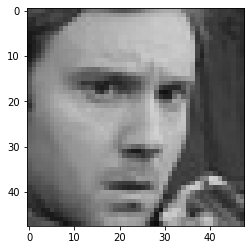

In [3]:
test_image = cv2.imread("./images/train/angry/0.jpg")
print("Shape of image nd-array : ", test_image.shape)
print("Sample image to check : \n")
plt.imshow(test_image)

**We notice from the above image data the following information about the images :**

* The images look to be black and white, however, there are 3 channels as observed in the shape of the ndarray.

* The images have width of 48 X 48 pixels and this is uniform across the dataset.

###**We know that image classifiers tend to perform better when we have larger images as training and testing inputs. In order to achieve this increase in size, we can increase the size of our images to 96 X 96 as this specific value will maintain the aspect ratio of our images. In addition to this, we will be benchmarking our own CNN architecture as against the ImageNet classifier. This classifier is trained on images which are of the size 96 X 96 and hence we can go with the same dimensions on our data.**###

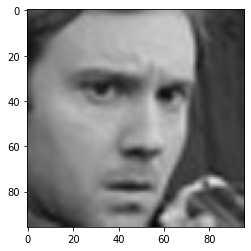

In [4]:
new_image_size = 96
new_image_array = cv2.resize(test_image, (new_image_size, new_image_size), interpolation=cv2.INTER_CUBIC)
plt.imshow(new_image_array)
plt.show()

###**We now notice that the image is resized however, the image seems to be blurred. In order to counter this, let us apply a sharpening operation**###

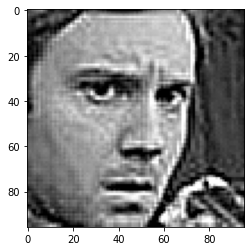

In [5]:
filter = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpened_image = cv2.filter2D(new_image_array, -1, filter)
plt.imshow(sharpened_image)
plt.show()

**We can see from this image that the enlargement and the sharpening have resulted in a much better image, which can potentially result in better results during classification.**

###**Next let us encode the names of the different classes into numerical values as this will make it easier for us to run metrics on the strength of our eventual classifier.**###

In [6]:
class_names = []
for dirpath, dirnames, filenames in os.walk("./images/train/"):
    if len(filenames) > 0 and dirpath != "./images/train/":
        class_name = os.path.basename(dirpath)
        class_names.append(class_name)
        
label_encoder = LabelEncoder()
label_encoder.fit(class_names)
encoded_class_names = label_encoder.transform(class_names)
decoded_class_names = label_encoder.inverse_transform(encoded_class_names)

print("The encoded classes are as follows : \n")

for (class_name, class_value) in zip(decoded_class_names, encoded_class_names):
  print(class_name," : ",class_value)

The encoded classes are as follows : 

sad  :  5
surprise  :  6
disgust  :  1
happy  :  3
neutral  :  4
fear  :  2
angry  :  0


###**Now let us prepare our data for training. To do this, let us apply our transformations for all the images in our training dataset. Then let us store all the updated image arrays into a python list.**###

In [7]:
training_data = []
for emotion in os.listdir("./images/train/"):
  if not emotion.startswith("."):
    path = os.path.join("./images/train",emotion)
    for image in os.listdir(path):
      image_array = cv2.imread(os.path.join(path, image))
      new_image_size = 48
      new_image_array = cv2.resize(image_array, (new_image_size, new_image_size))
      # filter = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
      # sharpened_image = cv2.filter2D(new_image_array, -1, filter)
      training_data.append([new_image_array/255.0, label_encoder.transform([emotion])[0]])

random.shuffle(training_data)
print("Sample of the training examples : \n")
print(training_data[0])

Sample of the training examples : 

[array([[[0.57254902, 0.57254902, 0.57254902],
        [0.44705882, 0.44705882, 0.44705882],
        [0.25098039, 0.25098039, 0.25098039],
        ...,
        [0.17254902, 0.17254902, 0.17254902],
        [0.22352941, 0.22352941, 0.22352941],
        [0.34117647, 0.34117647, 0.34117647]],

       [[0.4745098 , 0.4745098 , 0.4745098 ],
        [0.32941176, 0.32941176, 0.32941176],
        [0.19215686, 0.19215686, 0.19215686],
        ...,
        [0.16862745, 0.16862745, 0.16862745],
        [0.17647059, 0.17647059, 0.17647059],
        [0.24705882, 0.24705882, 0.24705882]],

       [[0.43137255, 0.43137255, 0.43137255],
        [0.30196078, 0.30196078, 0.30196078],
        [0.19215686, 0.19215686, 0.19215686],
        ...,
        [0.17254902, 0.17254902, 0.17254902],
        [0.15686275, 0.15686275, 0.15686275],
        [0.17647059, 0.17647059, 0.17647059]],

       ...,

       [[0.99607843, 0.99607843, 0.99607843],
        [1.        , 1.        

In [8]:
testing_data = []
for emotion in os.listdir("./images/validation/"):
  if not emotion.startswith("."):
    path = os.path.join("./images/validation/",emotion)
    for image in os.listdir(path):
      image_array = cv2.imread(os.path.join(path, image))
      new_image_size = 48 
      new_image_array = cv2.resize(image_array, (new_image_size, new_image_size))
      # filter = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
      # sharpened_image = cv2.filter2D(new_image_array, -1, filter)
      testing_data.append([new_image_array/255.0, label_encoder.transform([emotion])[0]])

print("Sample of the training examples : \n")
print(testing_data[0])

Sample of the training examples : 

[array([[[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.02352941, 0.02352941, 0.02352941]],

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.03921569, 0.03921569, 0.03921569],
        [0.01176471, 0.01176471, 0.01176471],
        [0.02745098, 0.02745098, 0.02745098]],

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01960784, 0.01960784, 0.01960784]],

       ...,

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941

In [9]:
X_train = []
y_train = []

for data in training_data:
    X_train.append(data[0])
    y_train.append(data[1])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for data in testing_data:
    X_test.append(data[0])
    y_test.append(data[1])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
backbone = keras.applications.ResNet50(
    input_shape=(48, 48, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 256)         4718848   
                                                                 
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 28,340,359
Trainable params: 28,287,239
Non-trainable params: 53,120
_______________________________________

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])
history_dict = history.history

Epoch 1/10
901/901 [==============================] - 88s 61ms/step - loss: 1.4200 - accuracy: 0.4640 - val_loss: 1.4612 - val_accuracy: 0.4515
Epoch 2/10
901/901 [==============================] - 52s 58ms/step - loss: 1.2259 - accuracy: 0.5372 - val_loss: 1.2365 - val_accuracy: 0.5361
Epoch 3/10
901/901 [==============================] - 54s 60ms/step - loss: 1.1271 - accuracy: 0.5783 - val_loss: 1.7836 - val_accuracy: 0.3401
Epoch 4/10
901/901 [==============================] - 51s 57ms/step - loss: 1.0478 - accuracy: 0.6079 - val_loss: 1.3271 - val_accuracy: 0.5007
Epoch 5/10
901/901 [==============================] - 51s 57ms/step - loss: 0.9726 - accuracy: 0.6364 - val_loss: 1.2957 - val_accuracy: 0.5610
Epoch 6/10
901/901 [==============================] - 51s 57ms/step - loss: 0.9015 - accuracy: 0.6671 - val_loss: 1.4933 - val_accuracy: 0.4693
Epoch 7/10
901/901 [==============================] - 51s 57ms/step - loss: 0.8136 - accuracy: 0.7010 - val_loss: 1.3112 - val_accuracy:

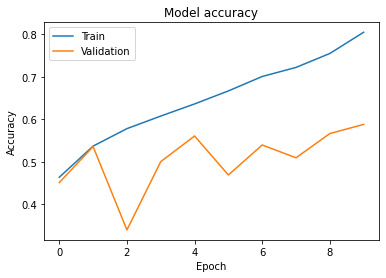

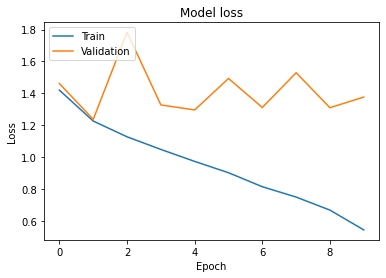

In [15]:
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation losses
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
predictions = np.argmax(model.predict(X_test), axis=-1)

221/221 [==============================] - 4s 14ms/step


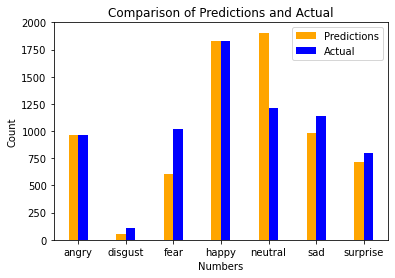

In [17]:
data1_counts = [np.count_nonzero(predictions == i) for i in range(0, 7)]
data2_counts = [np.count_nonzero(y_test == i) for i in range(0, 7)]

# Set up the x-axis and bar widths
x = np.arange(0, 7)
width = 0.2

# Plot the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data1_counts, width, color='orange', label='Predictions')
rects2 = ax.bar(x + width/2, data2_counts, width, color='blue', label='Actual')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Numbers')
ax.set_title('Comparison of Predictions and Actual')
ax.set_xticks(x)
ax.set_xticklabels(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.legend()

plt.show()

In [18]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50       967
           1       0.38      0.81      0.52        52
           2       0.29      0.49      0.36       607
           3       0.80      0.80      0.80      1833
           4       0.71      0.45      0.55      1905
           5       0.41      0.48      0.44       983
           6       0.69      0.76      0.72       719

    accuracy                           0.59      7066
   macro avg       0.54      0.61      0.56      7066
weighted avg       0.62      0.59      0.59      7066



In [19]:
for emotion in os.listdir("./images/train/"):
  if not emotion.startswith("."):
    path = os.path.join("./images/train",emotion)
    for image in os.listdir(path):
      image_array = cv2.imread(os.path.join(path, image))
      flipped_img = cv2.flip(image_array, 1)
      blurred_img = cv2.GaussianBlur(image_array, (3, 3), 0)
      cv2.imwrite(os.path.join("./images/train/",emotion,"flipped_" + image), flipped_img)
      cv2.imwrite(os.path.join("./images/train/",emotion,"smoothed_" + image), flipped_img)

In [20]:
training_data = []
for emotion in os.listdir("./images/train/"):
  if not emotion.startswith("."):
    path = os.path.join("./images/train",emotion)
    for image in os.listdir(path):
      image_array = cv2.imread(os.path.join(path, image))
      new_image_size = 48 
      new_image_array = cv2.resize(image_array, (new_image_size, new_image_size))
      training_data.append([new_image_array/255.0, label_encoder.transform([emotion])[0]])

random.shuffle(training_data)
print("Sample of the training examples : \n")
print(training_data[0])

Sample of the training examples : 

[array([[[0.21176471, 0.21176471, 0.21176471],
        [0.2745098 , 0.2745098 , 0.2745098 ],
        [0.25098039, 0.25098039, 0.25098039],
        ...,
        [0.39607843, 0.39607843, 0.39607843],
        [0.34117647, 0.34117647, 0.34117647],
        [0.31764706, 0.31764706, 0.31764706]],

       [[0.20784314, 0.20784314, 0.20784314],
        [0.25882353, 0.25882353, 0.25882353],
        [0.27058824, 0.27058824, 0.27058824],
        ...,
        [0.36470588, 0.36470588, 0.36470588],
        [0.32156863, 0.32156863, 0.32156863],
        [0.30588235, 0.30588235, 0.30588235]],

       [[0.20784314, 0.20784314, 0.20784314],
        [0.23529412, 0.23529412, 0.23529412],
        [0.26666667, 0.26666667, 0.26666667],
        ...,
        [0.23529412, 0.23529412, 0.23529412],
        [0.22352941, 0.22352941, 0.22352941],
        [0.2745098 , 0.2745098 , 0.2745098 ]],

       ...,

       [[0.62352941, 0.62352941, 0.62352941],
        [0.64313725, 0.64313725

In [21]:
X_train = []
y_train = []

for data in training_data:
    X_train.append(data[0])
    y_train.append(data[1])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for data in testing_data:
    X_test.append(data[0])
    y_test.append(data[1])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [35]:
backbone = keras.applications.ResNet50(
    input_shape=(48, 48, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [36]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         4718848   
                                                                 
 batch_normalization_2 (Batc  (None, 2, 2, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         295040    
                                                                 
 batch_normalization_3 (Batc  (None, 2, 2, 128)        512       
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_3   (None, 128)             

In [37]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")

In [38]:
history = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), callbacks=[early_stopping])
history_dict = history.history

Epoch 1/4
2702/2702 [==============================] - 182s 56ms/step - loss: 1.3150 - accuracy: 0.4998 - val_loss: 1.4385 - val_accuracy: 0.4680
Epoch 2/4
2702/2702 [==============================] - 149s 55ms/step - loss: 1.0917 - accuracy: 0.5905 - val_loss: 1.2986 - val_accuracy: 0.5318
Epoch 3/4
2702/2702 [==============================] - 150s 55ms/step - loss: 0.9547 - accuracy: 0.6467 - val_loss: 1.7814 - val_accuracy: 0.4298
Epoch 4/4
2702/2702 [==============================] - 149s 55ms/step - loss: 0.8122 - accuracy: 0.7034 - val_loss: 1.1992 - val_accuracy: 0.5773


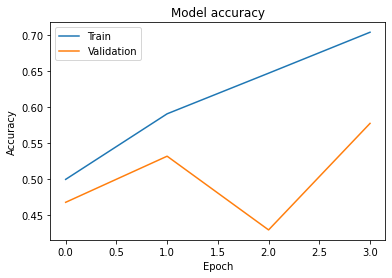

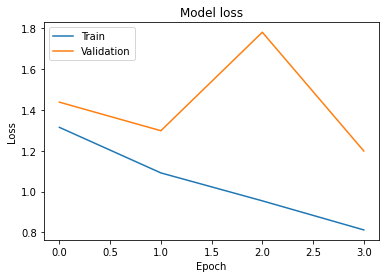

In [39]:
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation losses
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
predictions = np.argmax(model.predict(X_test), axis=-1)

221/221 [==============================] - 4s 14ms/step


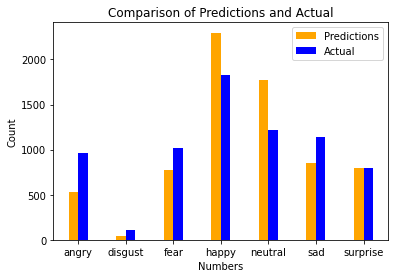

In [41]:
data1_counts = [np.count_nonzero(predictions == i) for i in range(0, 7)]
data2_counts = [np.count_nonzero(y_test == i) for i in range(0, 7)]

# Set up the x-axis and bar widths
x = np.arange(0, 7)
width = 0.2

# Plot the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data1_counts, width, color='orange', label='Predictions')
rects2 = ax.bar(x + width/2, data2_counts, width, color='blue', label='Actual')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xlabel('Numbers')
ax.set_title('Comparison of Predictions and Actual')
ax.set_xticks(x)
ax.set_xticklabels(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.legend()

plt.show()

In [42]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.34      0.61      0.43       533
           1       0.22      0.52      0.31        46
           2       0.33      0.43      0.37       769
           3       0.89      0.71      0.79      2296
           4       0.67      0.46      0.54      1772
           5       0.37      0.49      0.42       849
           6       0.69      0.68      0.69       801

    accuracy                           0.58      7066
   macro avg       0.50      0.56      0.51      7066
weighted avg       0.64      0.58      0.60      7066

